In [1]:
import sys
from pathlib import Path

# Notebook ka folder
NOTEBOOK_DIR = Path().resolve()

# Project root = parent folder
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Add project root to import path
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: D:\Langchain_LangGraph_03-12-2025\MyProject


In [2]:
#now importing all the Module which is used to build the AI Model.
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from exception import CustomException
from logger_config import logger
import os,sys

#using openai chat model and embedding models
from langchain_openai import ChatOpenAI,OpenAIEmbeddings

#using groq chat model 
from langchain_groq import ChatGroq

#using open source chat model from hugging Face
from langchain_huggingface import ChatHuggingFace,HuggingFaceEmbeddings,HuggingFaceEndpoint

from config import *

from langchain_core.runnables import RunnableBranch,RunnableLambda,RunnableParallel,RunnableSequence,RunnablePassthrough

[2025-12-04 21:49:12,944]-config_variable.py-INFO -Loading the environment Variable
[2025-12-04 21:49:12,948]-config_variable.py-INFO -Environment Variable successfully Loaded


In [3]:
%pwd

'd:\\Langchain_LangGraph_03-12-2025\\MyProject\\notebooks'

In [4]:
#import Langgraph related Modules
import langgraph
from langgraph.graph import StateGraph,START,END
from dataclasses import dataclass
from typing import TypedDict
from typing import Literal,List,Annotated
from langchain_core.messages import AnyMessage,AIMessage,HumanMessage,ToolMessage

from pydantic import BaseModel #using this class we can perform validation to schema

from langgraph.prebuilt import tool_node,tools_condition #in this class we put all tools together
#tools_condition wrt to tool msg it will route the flow data to ttol node to perform execution

from langchain_core.tools import tool,Tool,StructuredTool

from langgraph.graph.message import BaseMessage #this is special class which hold every mesaage init.



## step:1) defining the models components

In [5]:
model1 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.2 #we call as creative parameter
)
model1

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002C2713791E0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002C2709789A0>, root_client=<openai.OpenAI object at 0x000002C2714DBBE0>, root_async_client=<openai.AsyncOpenAI object at 0x000002C2719DD150>, temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [6]:
model2 = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2 #we call as creative parameter
)
model2

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002C271AD20E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002C271B089D0>, model_name='llama-3.1-8b-instant', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = HuggingFaceEndpoint(  
repo_id="meta-llama/Llama-3.1-8B-Instruct",  
task="text-generation",  
max_new_tokens=512,  
do_sample=False,  
repetition_penalty=1.03,  
)  

model3 = ChatHuggingFace(llm=llm, verbose=True)
model3

ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='meta-llama/Llama-3.1-8B-Instruct', repetition_penalty=1.03, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='meta-llama/Llama-3.1-8B-Instruct', client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, async_client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, task='text-generation'), model_id='meta-llama/Llama-3.1-8B-Instruct', model_kwargs={})

## building different type of complex workflows using LangGraph

### 1) building sequential workflow

#### defining state or memory schema for this workflow

In [8]:
from pydantic import Field
from typing import Optional
class SequentialStateSchema(BaseModel):
    weight : Annotated[float,Field(...,description="Provide the weights in kg",examples=[10,20],gt=0,lt=250)]
    height : Annotated[float,Field(...,description="Provide the height in cms",examples=[120,134],gt=0,lt=500)]
    bmi: Annotated[
        Optional[float],
        Field(
            default=None,
            description="BMI calculated using height and weight",
            examples=[21.5, 30.2]
        )
    ]
    
    bmi_cat: Annotated[
        Optional[str],
        Field(
            default=None,
            description="Based On BMI value Categorized the Person ",
           
        )
    ]

#### step:2) defining the stategraph class object and passing the state schema init

In [9]:
graph = StateGraph(state_schema=SequentialStateSchema)
graph

In [10]:
#defining the structure output schema
class Bmi_Schema(BaseModel):
    BMI : Annotated[float,
        Field(
            ...,
            description="BMI calculated using height and weight",
    
        )
    ]

In [11]:
def BmiCalculator(state:SequentialStateSchema) ->SequentialStateSchema:
    #fetching height and weight input from state 
    weight = state.weight
    height = state.height
    
    #wrapping llm with structure output.
    llm_wrap_output = model2.with_structured_output(schema=Bmi_Schema)
    
    
    #changing this dynamic inputs to structure instruction Prompt.
    prompt = PromptTemplate(
    template="""
    You are an expert in calculating BMI.

    Given:
    - Weight: {weight} kg
    - Height: {height} cm

    Use the formula:
    BMI = weight(kg) / ( (height(cm) / 100) ^ 2 )

    Calculate the BMI accurately and return only the numeric value.
    """,
    input_variables=['weight', 'height']
)

    
    #creating sequrential chain to perform task.
    seq_chain = prompt | llm_wrap_output
    
    response = seq_chain.invoke(input={'weight': weight, 'height': height})
    
    return {
        'bmi':response.BMI
    }
    
    

In [12]:
def bmi_category(state:SequentialStateSchema) ->SequentialStateSchema:
    #fetching height and weight input from state 
    weight = state.weight
    height = state.height
    bmi = state.bmi
    
    
    if bmi < 18.5:
        bmi_cat =  "Underweight"
    elif 18.5 <= bmi < 25:
        bmi_cat =  "Normal Weight"
    elif 25 <= bmi < 30:
        bmi_cat =  "Overweight"
    elif 30 <= bmi < 35:
        bmi_cat =  "Obesity Class I"
    elif 35 <= bmi < 40:
        bmi_cat =  "Obesity Class II"
    else:
        bmi_cat =  "Obesity Class III (Morbid Obesity)"
   
    
    
    return {
        'bmi_cat':bmi_cat
    }
    
    

### now building nodes and edges using graph object

In [13]:
graph.add_edge(start_key=START,end_key="BmiCalculator")
graph.add_node(node="BmiCalculator",action=BmiCalculator)
graph.add_edge(start_key="BmiCalculator",end_key="Bmi_Detail")
graph.add_node(node="Bmi_Detail",action=bmi_category)
graph.add_edge(start_key="BmiCalculator",end_key=END)

### now compiling my workflow

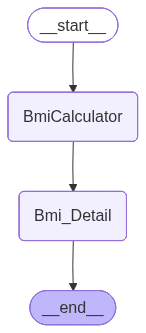

In [14]:
worklfow = graph.compile()
worklfow

In [15]:
#initializing  the state schema and passing input to start node.
state = SequentialStateSchema(weight=115,height=175)

result = worklfow.invoke(input=state)
result

[2025-12-04 21:49:14,599]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'weight': 115.0,
 'height': 175.0,
 'bmi': 34.28571428571429,
 'bmi_cat': 'Obesity Class I'}

### case:b) sequential workflow (knowna as chaining in sequential workflow)

In [16]:
#defining state schema for chaining in sequential workflow.
class ChainingSchema(TypedDict):
    topic : str
    blog  : str | None
    outline_topic : str | None

In [17]:
#again defining the stategraph class object and passing the state schema init .that memory will be share by throughout workflow.
graph2 = StateGraph(state_schema=ChainingSchema)
graph2

### now building the nodes and edges to graph

In [18]:
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()

In [19]:
#now building the node for the graph
def topicOutline(state2:ChainingSchema) ->ChainingSchema:
    #fetching the topic from state and generating the outline out of it.
    topic = state2['topic']
    
    #converting dynamic user prompt to structure instruction prompt
    prompt = PromptTemplate(
        template=f"""
         You are an expert content writer.

        Your task:
        - Generate a clear, structured outline based on the topic: "{topic}"
        - Limit the outline to 4–6 lines
        - Keep it concise, meaningful, and relevant
        
        """,
        input_variables=['topic']
    )
    
    #passing the prompt to llm model using chains.
    chains = prompt | model2 | parser
    
    #chains is runnable so we have to invoke to get response.
    response =chains.invoke(input={"topic":topic})
    
    #updating the outline into state 
    return {
        'outline_topic':response
    }

In [20]:
def GenerateBlog(state2: ChainingSchema) -> ChainingSchema:
    
    topic = state2['topic']
    outline_topic = state2['outline_topic']

    prompt = PromptTemplate(
        template="""
        You are an expert blog writer.

        Task:
        - Generate a short blog based on:
            • Topic: "{topic}"
            • Outline: "{outline_topic}"
        - Blog should contain 4 to 6 lines.
        - Keep it concise, meaningful, and easy to read.

        Return only the blog content, no explanation.
        """,
        input_variables=["topic", "outline_topic"]
    )

    chains2 = prompt | model1 | parser

    response2 = chains2.invoke(
        {"topic": topic, "outline_topic": outline_topic}
    )

    return {
        "blog": response2
    }


In [21]:
graph2.add_node(node="topicOutline",action=topicOutline)
graph2.add_edge(start_key=START,end_key="topicOutline")

graph2.add_node(node="GenerateBlog",action=GenerateBlog)
graph2.add_edge(start_key="topicOutline",end_key="GenerateBlog")
graph2.add_edge(start_key='GenerateBlog',end_key=END)

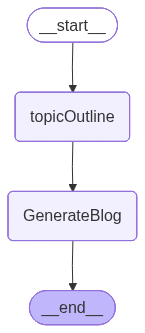

In [22]:
#now defining the workflow.
workflow2 = graph2.compile()
workflow2

In [23]:
#initialing the state schema for sequential of chainingprompt
state2 = ChainingSchema(topic="AI in Banking Sector Impact")

#now this state2 object we are passing initally to my workflow.
result = workflow2.invoke(input=state2)
result

[2025-12-04 21:49:15,138]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-04 21:49:17,010]-_client.py-INFO -HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'topic': 'AI in Banking Sector Impact',
 'blog': 'AI has revolutionized the banking sector, enhancing customer experience, risk management, and operational efficiency. While it brings benefits like increased efficiency and improved security, challenges such as job displacement and data privacy concerns exist. The future of AI in banking looks promising, with potential applications yet to be explored.',
 'outline_topic': 'Here\'s a clear and structured outline on "AI in Banking Sector Impact":\n\n**I. Introduction**\n- Brief overview of AI in banking\n- Importance of AI in modern banking\n\n**II. Key Impact Areas**\n- **1. Customer Experience**: Personalized services, chatbots, and virtual assistants\n- **2. Risk Management**: Fraud detection, credit scoring, and predictive analytics\n- **3. Operational Efficiency**: Automation, process optimization, and data analysis\n\n**III. Benefits and Challenges**\n- Advantages: Increased efficiency, improved customer satisfaction, and enhanced s